#### Cross calibrate co-located Dorado and Pontus fluorescence and backscatter data

This Notebook is part of the auv-python project (https://github.com/mbari-org/auv-python).

In [1]:
import holoviews as hv
import hvplot.pandas
import numpy as np
import pandas as pd
import pooch
import statsmodels.api as sm
import warnings
from scipy.interpolate import griddata
from holoviews.operation.datashader import rasterize

hv.extension("bokeh")
warnings.filterwarnings(action='ignore')

The July 2022 Dorado Diamond mission sampled the same water as a Pontus deployment that month. Here is the Share this view link for the data in STOQS: http://stoqs.mbari.org/p/wa8_j4M. The NW leg of the diamond has Dorado & Pontus sample about 3 km apart from each other:

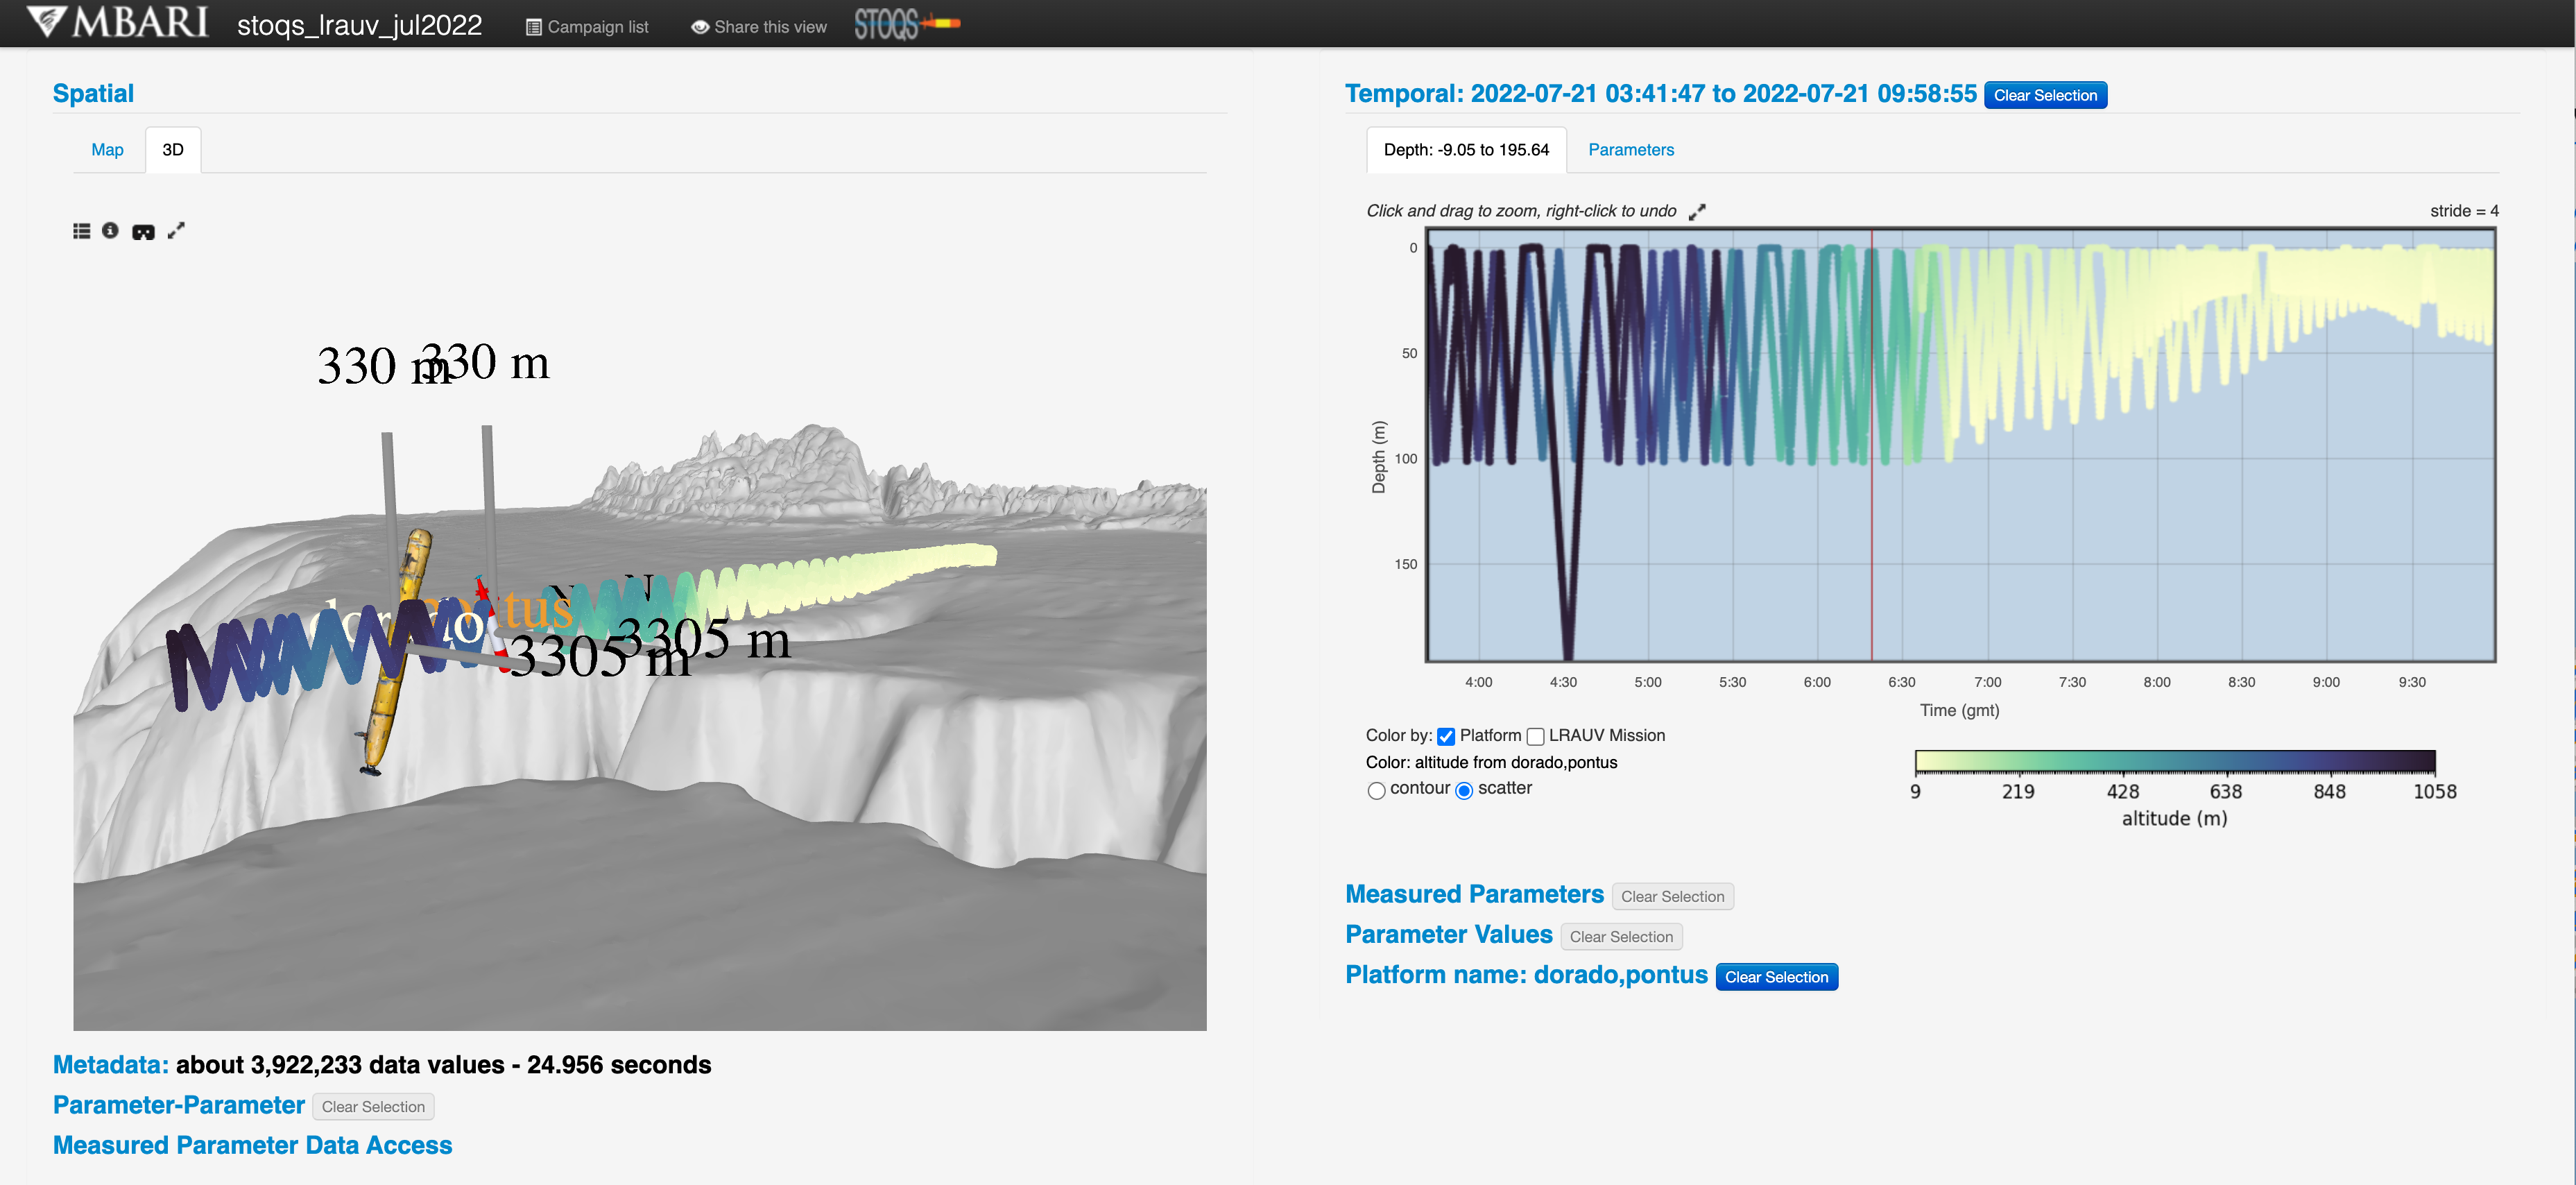

In [2]:
from IPython.display import Image

Image(filename="images/dorado_pontus_july_2022.png")

Extract 6.5 hours of data from STOQS for this time period and explore the data from dorado and pontus. (If you get a ValueError then update the known_hash value with the one that was got.)

In [3]:
%%time
# Construct the url to retrieve the data from the STOQS database:
parms = [
    "ctd1_salinity",
    "ctd1_temperature (degree_Celsius)",
    "ecopuck_bbp700 (m-1)",
    "ecopuck_chl (ug/l)",
    "hs2_bbp420 (m-1)",
    "hs2_bbp700 (m-1)",
    "hs2_fl700",
    "salinity (psu)",
    "sigmat",
    "temperature (degC)",
    "particulatebackscatteringcoeff470nm (1/m)",
    "particulatebackscatteringcoeff650nm (1/m)",
    "chlorophyll (ug/l)",
]
stoqs_url = "https://tethysviz.shore.mbari.org/stoqs_lrauv_jul2022_t/api/measuredparameter.parquet?"
stoqs_url += "parameter__name=" + "&parameter__name=".join(parms)
stoqs_url += "&measurement__instantpoint__activity__platform__name=pontus"
stoqs_url += "&measurement__instantpoint__activity__platform__name=dorado"
stoqs_url += "&measurement__instantpoint__timevalue__gt=2022-07-21+03:30:00"
stoqs_url += "&measurement__instantpoint__timevalue__lt=2022-07-21+10:00:00"
stoqs_url += "&collect=name&include=activity__name"

data_file = pooch.retrieve(url=stoqs_url, known_hash=None)
df = pd.read_parquet(data_file)
df.describe()

CPU times: user 108 ms, sys: 33.6 ms, total: 142 ms
Wall time: 127 ms


name,chlorophyll (ug/l),ctd1_salinity,ctd1_temperature (degree_Celsius),ecopuck_bbp700 (m-1),ecopuck_chl (ug/l),hs2_bbp420 (m-1),hs2_bbp700 (m-1),hs2_fl700,particulatebackscatteringcoeff470nm (1/m),particulatebackscatteringcoeff650nm (1/m),salinity (psu),sigmat,temperature (degC)
count,11701.000000,23401.000000,23401.000000,23401.000000,23401.000000,23401.000000,23401.000000,23401.000000,11701.000000,11701.000000,11701.000000,35102.000000,11701.000000
mean,0.707319,33.896407,10.808950,0.002257,1.586733,0.001115,0.002032,0.000416,0.003049,0.001800,33.915729,25.963425,10.536446
std,0.973498,0.091523,1.342609,0.001927,2.082186,0.001744,0.001720,0.000532,0.001916,0.001356,0.085294,0.285698,1.225371
min,0.047999,33.516702,9.011533,0.000682,0.043070,-0.001924,0.000612,-0.005254,0.001267,0.000552,33.565521,25.288946,9.150782
25%,0.083999,33.840492,9.738690,0.000944,0.128082,-0.000118,0.000846,0.000067,0.001638,0.000839,33.860683,25.827625,9.635157
50%,0.209999,33.889121,10.308539,0.001140,0.369645,0.000390,0.001008,0.000113,0.002176,0.001127,33.926964,26.029715,10.115625
75%,0.821994,33.967816,11.579579,0.003667,2.974750,0.002279,0.003319,0.000697,0.003904,0.002397,33.986092,26.199568,10.803125
max,3.959984,34.421970,13.674449,0.025480,8.080436,0.014563,0.007014,0.001932,0.029897,0.012389,34.095287,26.421911,13.678125


In [ ]:
# Make dataframe modified with index columns converted to regular columns:
dfm = df.reset_index()

In [ ]:
# Function to create a scatter plot of a single parameter from a platform
def scatter_plot(df, platform, parameter, height=200):
    return (
        df[df["platform"] == platform]
        .hvplot.scatter(
            x="latitude",
            y="depth",
            c=parameter,
            cmap="viridis",
            colorbar=True,
            width=800,
            height=height,
        )
        .opts(invert_yaxis=True, title=f"{platform} {parameter}")
    )


# Backscatter at 700nm/650nm is a good proxy for particulate matter
dorado_plot = scatter_plot(dfm, "dorado", "ecopuck_bbp700 (m-1)")
pontus_plot = scatter_plot(dfm, "pontus", "particulatebackscatteringcoeff650nm (1/m)")
(dorado_plot + pontus_plot).cols(1)

In [ ]:
# Fluorescence is a good proxy for chlorophyll
dorado_plot = scatter_plot(dfm, "dorado", "ecopuck_chl (ug/l)")
pontus_plot = scatter_plot(dfm, "pontus", "chlorophyll (ug/l)")
(dorado_plot + pontus_plot).cols(1)

In [ ]:
# Function to create a gridded mesh and plot of a single parameter from a platform
def grid_plot(df, platform, parameter, height=200):
    dfp = df[parameter].dropna().reset_index()
    lats = np.linspace(36.75, 36.9, 3000)
    depths = np.linspace(0.0, 150.0, 300)
    g_z = griddata(
        dfp[["latitude", "depth"]].values,
        dfp[parameter].values,
        (lats[None, :], depths[:, None]),
        method="linear",
        rescale=True,
    )
    g_z = np.flip(g_z, axis=0)
    return (
        hv.Image(
            g_z,
            bounds=(
                dfm["latitude"].min(),
                dfm["depth"].min(),
                dfm["latitude"].max(),
                dfm["depth"].max(),
            ),
        ).opts(
            width=800,
            height=height,
            title=f"{platform} {parameter}",
            colorbar=True,
            cmap="viridis",
            invert_yaxis=True,
            logz=True,
        ),
        g_z,
    )


# Backscatter at 700nm/650nm - _bsr
dorado_plot, dorado_data_bsr = grid_plot(df, "dorado", "ecopuck_bbp700 (m-1)")
pontus_plot, pontus_data_bsr = grid_plot(
    df, "pontus", "particulatebackscatteringcoeff650nm (1/m)"
)
(dorado_plot + pontus_plot).cols(1)

In [ ]:
# Chlorophyll fluorescence - _chl
dorado_plot, dorado_data_chl = grid_plot(df, "dorado", "ecopuck_chl (ug/l)")
pontus_plot, pontus_data_chl = grid_plot(df, "pontus", "chlorophyll (ug/l)")
(dorado_plot + pontus_plot).cols(1)

In [ ]:
# Function to make dataframe of gridded data, remove nan rows, plot, and compute regression
def biplot(df, x_plat, y_plat, x_parm, y_parm, log=False):
    x_data = grid_plot(df, x_plat, x_parm)[1].flatten()
    y_data = grid_plot(df, y_plat, y_parm)[1].flatten()
    if log:
        dfg = pd.DataFrame({x_plat: np.log10(x_data), y_plat: np.log10(y_data)})
    else:
        dfg = pd.DataFrame({x_plat: x_data, y_plat: y_data})
    dfa = dfg[[x_plat, y_plat]].dropna()
    results = sm.OLS(dfa[y_plat], sm.add_constant(dfa[x_plat])).fit()
    print(results.summary())
    if log:
        X = f"log10({x_plat} {x_parm})"
        Y = f"log10({y_plat} {y_parm})"
    else:
        X = f"{x_plat} {x_parm}"
        Y = f"{y_plat} {y_parm}"
    title = f"{Y} = \n\t{results.params[1]:.4f} * {X} + {results.params[0]:.4f}"
    slope_plot = hv.Slope.from_scatter(hv.Scatter(dfa.to_numpy())).opts(
        line_width=1, color="red"
    )
    pts = hv.Points(dfa, [x_plat, y_plat])
    title = title + f" (r-squared={results.rsquared:.4f})"
    print(f"\nRegression: {title}\n")
    scatter_plot = (
        rasterize(pts)
        .opts(width=700, height=700, title=title, colorbar=True, cmap="viridis")
        .opts(tools=["hover"])
    )
    return scatter_plot * slope_plot

In [ ]:
# Linear backscatter at 700nm/650nm - prediction for pontus from dorado
biplot(
    df,
    "dorado",
    "pontus",
    "ecopuck_bbp700 (m-1)",
    "particulatebackscatteringcoeff650nm (1/m)",
    log=False,
)

In [ ]:
# Linear chlorophyll - prediction for pontus from dorado
biplot(df, "dorado", "pontus", "ecopuck_chl (ug/l)", "chlorophyll (ug/l)", log=False)

In [ ]:
# Logarithmic backscatter at 700nm/650nm - prediction for pontus from dorado
biplot(
    df,
    "dorado",
    "pontus",
    "ecopuck_bbp700 (m-1)",
    "particulatebackscatteringcoeff650nm (1/m)",
    log=True,
)

In [ ]:
# Logarithmic chlorophyll - prediction for pontus from dorado
biplot(df, "dorado", "pontus", "ecopuck_chl (ug/l)", "chlorophyll (ug/l)", log=True)

We can bypass the Dorado Ecopuck and produce regressions directly from Pontus to Dorado's HS2 -- which it the transfer function needed on the vehicle.

In [ ]:
# Linear backscatter at 650nm/700nm - prediction for dorado from pontus
biplot(df, "pontus", "dorado", "particulatebackscatteringcoeff650nm (1/m)",  "hs2_bbp700 (m-1)")

In [ ]:
# Linear backscatter at 470nm/420nm - prediction for dorado from pontus
biplot(df, "pontus", "dorado", "particulatebackscatteringcoeff470nm (1/m)",  "hs2_bbp420 (m-1)")

In [ ]:
# Linear chlorophyll - prediction for dorado from pontus
biplot(df, "pontus", "dorado", "chlorophyll (ug/l)", "hs2_fl700")